Import necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV


# File system management
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Import the data

In [22]:
df_train = pd.read_csv('indian_food.csv')
df_train.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,West Bengal,East


Selecting required columns and rows

In [23]:
from io import StringIO

col = ['diet', 'ingredients']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['ingredients'])]
df_train.columns = ['diet', 'ingredients']

df_train['category_id'] = df_train['diet'].factorize()[0]

category_id_df_train = df_train[['diet', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'diet']].values)

df_train.head()

,diet,ingredients,category_id
0,vegetarian,"Maida flour, yogurt, oil, sugar",0
1,vegetarian,"Gram flour, ghee, sugar",0
2,vegetarian,"Carrots, milk, sugar, ghee, cashews, raisins",0
3,vegetarian,"Flour, ghee, kewra, milk, clarified butter, su...",0
4,vegetarian,"Milk powder, plain flour, baking powder, ghee,...",0


In [24]:
df_train['diet'].value_counts()

vegetarian        226
non vegetarian     29
Name: diet, dtype: int64

Plot it

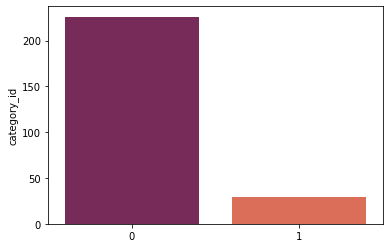

In [25]:
sns.barplot(df_train['category_id'].value_counts().index, df_train['category_id'].value_counts(), palette = 'rocket')

In [26]:
vegetarian = df_train[df_train['category_id'] == 0]['ingredients']
vegetarian.values[1]

'Gram flour, ghee, sugar'

In [27]:
non_vegetarian = df_train[df_train['category_id'] == 1]['ingredients']
non_vegetarian.values[1]

'Boiled pork, onions, chillies, ginger and garlic'

Text Data Preprocessing

In [28]:
df_train['ingredients'][:5]

0                      Maida flour, yogurt, oil, sugar
1                              Gram flour, ghee, sugar
2         Carrots, milk, sugar, ghee, cashews, raisins
3    Flour, ghee, kewra, milk, clarified butter, su...
4    Milk powder, plain flour, baking powder, ghee,...
Name: ingredients, dtype: object

In [29]:
def clean_text(ingredients):
    ingredients = ingredients.lower()
    ingredients = re.sub('\[.*?\]', '', ingredients)
    ingredients = re.sub('https?://\S+|www\.\S+', '', ingredients)
    ingredients = re.sub('<.*?>+', '', ingredients)
    ingredients = re.sub('[%s]' % re.escape(string.punctuation), '', ingredients)
    ingredients = re.sub('\n', '', ingredients)
    ingredients = re.sub('\w*\d\w*', '', ingredients)
    
    return ingredients

df_train['ingredients'] = df_train['ingredients'].apply(lambda x: clean_text(x))

df_train['ingredients'].head()

0                         maida flour yogurt oil sugar
1                                gram flour ghee sugar
2              carrots milk sugar ghee cashews raisins
3    flour ghee kewra milk clarified butter sugar a...
4    milk powder plain flour baking powder ghee mil...
Name: ingredients, dtype: object

WordCloud 

In [34]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

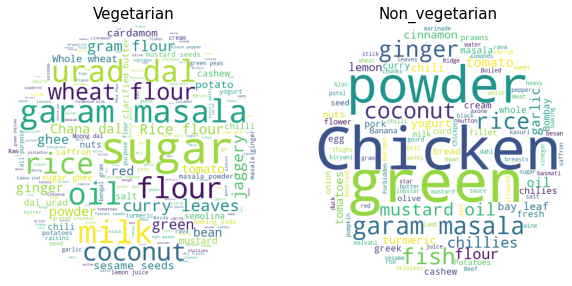

In [42]:
from wordcloud import WordCloud

char_mask = np.array(Image.open("1148109.png"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 10])
wordcloud1 = WordCloud(background_color = 'white', width = 600, height = 400, mask = char_mask).generate(" ".join(vegetarian))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Vegetarian', fontsize = 15)

wordcloud2 = WordCloud( background_color='white', width=600, height=400, mask = char_mask).generate(" ".join(non_vegetarian))


ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non_vegetarian', fontsize = 15)
plt.savefig('vegetarian')

Tokenizing the training

In [43]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
df_train['ingredients'] = df_train['ingredients'].apply(lambda x: tokenizer.tokenize(x))
df_train['ingredients'].head()

0                   [maida, flour, yogurt, oil, sugar]
1                           [gram, flour, ghee, sugar]
2       [carrots, milk, sugar, ghee, cashews, raisins]
3    [flour, ghee, kewra, milk, clarified, butter, ...
4    [milk, powder, plain, flour, baking, powder, g...
Name: ingredients, dtype: object

Stopwords removal

In [44]:
def remove_stopwords(description):
    words = [w for w in description if w not in stopwords.words('english')]
    return words

df_train['ingredients'] = df_train['ingredients'].apply(lambda x: remove_stopwords(x))

df_train.head()

,diet,ingredients,category_id
0,vegetarian,"[maida, flour, yogurt, oil, sugar]",0
1,vegetarian,"[gram, flour, ghee, sugar]",0
2,vegetarian,"[carrots, milk, sugar, ghee, cashews, raisins]",0
3,vegetarian,"[flour, ghee, kewra, milk, clarified, butter, ...",0
4,vegetarian,"[milk, powder, plain, flour, baking, powder, g...",0


Token normalization

In [45]:
text = 'feet cats wolves talked'

tokenizer = nltk.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

#stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

#lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [46]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

df_train['ingredients'] = df_train['ingredients'].apply(lambda x: combine_text(x))

df_train['ingredients']
df_train.head()

,diet,ingredients,category_id
0,vegetarian,maida flour yogurt oil sugar,0
1,vegetarian,gram flour ghee sugar,0
2,vegetarian,carrots milk sugar ghee cashews raisins,0
3,vegetarian,flour ghee kewra milk clarified butter sugar a...,0
4,vegetarian,milk powder plain flour baking powder ghee mil...,0


Getting it all together - A Text Preprocessing function

In [47]:
def text_preprocessing(ingredients):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(ingredients)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

Transforming tokens to a vector Bag of words

In [48]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_train['ingredients'])


Keeping only non-zero elements to preserve space

In [49]:
print(train_vectors[0].todense())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0]]


TFIDF Features

In [50]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1,2))
train_tfidf = tfidf.fit_transform(df_train['ingredients'])

Building a text classification model

Logistic Regression classifier

In [52]:
clf = LogisticRegression(C = 1.0)
scores = model_selection.cross_val_score(clf, train_vectors, df_train['category_id'], cv = 5, scoring = 'f1')
scores

array([0.33333333, 0.        , 0.6       , 0.28571429, 0.28571429])

In [53]:
clf.fit(train_vectors, df_train['category_id'])

LogisticRegression()

Naives Bayes Classifier

In [54]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, df_train['category_id'], cv=5, scoring="f1")
scores

array([0.6       , 0.42857143, 0.47058824, 0.57142857, 0.5       ])